# ChiantiPy Continuum Refactor
Testing some improvements to the `continuum` class in ChiantiPy. Here, we'll try to implement a barebones version for testing purposes.

In [1]:
import os

import numpy as np
from scipy.interpolate import splrep,splev
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import ChiantiPy.core as ch
import ChiantiPy.tools.constants as ch_const
import ChiantiPy.tools.io as ch_io
import ChiantiPy.tools.data as ch_data
import ChiantiPy.tools.util as ch_util
import hissw

%matplotlib inline

/home/wtb2/anaconda3/envs/sunpy-aia-response/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


 using cli
 using CLI for selections
 reading chiantirc file


In [2]:
ch_data.Defaults['abundfile'] = 'sun_coronal_1992_feldman'
ch_data.Defaults['ioneqfile'] = 'chianti'
ch_data.Defaults['flux'] = 'photon'

## Improved Implementation of `continuum` class

In [3]:
invcm = (const.h.cgs*const.c.cgs)

In [ ]:
class ContinuumTest(object):
    """
    Testing new continuum class
    """
    
    @u.quantity_input(temperature=u.K)
    def __init__(self,ion_name,temperature,use_photons=True):
        self.temperature = temperature
        self.Z = ch_util.el2z(ion_name.split('_')[0])
        self.z = int(ion_name.split('_')[1])
        if self.z == 1:
            raise ValueError('No continuum emission for neutrals!')
        self.abundance = ch_io.abundanceRead(abundancename=ch_data.Defaults['abundfile'])['abundance'][self.Z-1]
        self.ionization_potential = (ch_data.Ip[self.Z-1,self.z-1]*u.eV).to(u.erg)
        self.use_photons = use_photons
        tmp = ch.ioneq(self.Z)
        tmp.load(ch_data.Defaults['ioneqfile'])
        ioneq = splev(self.temperature.value,splrep(tmp.Temperature,tmp.Ioneq[self.z,:]))
        self.ioneq = np.where(ioneq<0.,0.,ioneq)
    
    @u.quantity_input(wavelength=u.angstrom)
    def free_bound(self,wavelength,use_verner=True):
        """
        Calculate free-bound emission
        """
        #from IPython.core.debugger import Tracer; Tracer()()

        # calculate constant
        fb_constant = (2./np.sqrt(2.*np.pi)/(4.*np.pi*u.steradian)
                       /(const.h.cgs*(const.c.cgs**3)*(const.m_e.cgs*const.k_B.cgs)**(3./2.)))
                
        # read free-bound level information for recombined ion
        recombined_fblvl = ch_io.fblvlRead('.'.join([ch_util.zion2filename(self.Z,self.z),'fblvl']))
        # read free-bound level information for recombining ion
        recombining_fblvl = ch_io.fblvlRead('.'.join([ch_util.zion2filename(self.Z,self.z+1),'fblvl']))        
        # check if no fblvl files are available
        if 'errorMessage' in recombined_fblvl:
            raise ValueError('No free-bound information available for {}'.format(ch_util.zion2name(self.Z,self.z)))
        # calculate photon energy from wavelength
        photon_energy = invcm/wavelength.to(u.cm)
        # get the multiplicity of the ground state of the recombining ion
        if 'errorMessage' in recombining_fblvl:
            omega_0 = 1.
        else:
            omega_0 = recombining_fblvl['mult'][0]
        
        # calculate a few different factors
        energy_over_temp_factor = (np.outer(1./(self.temperature**1.5),photon_energy**5.)
                                  *((photon_energy.unit**5)/(self.temperature.unit**(3./2.))))
        
        # sum over the recombined levels
        sum_factor = np.zeros((len(self.temperature),len(wavelength)))*u.cm**2
        #print(photon_energy)
        for i,omega_i in enumerate(recombined_fblvl['mult']):
            ip = self.ionization_potential - recombined_fblvl['ecm'][i]/u.cm*invcm
            if ip < 0. or np.all(np.max(photon_energy) < (self.ionization_potential - ip)):
                continue
            if i==0 and use_verner:
                # use V&Y for ground states
                cross_section = self.verner_cross_sections(photon_energy)
            else:
                # otherwise use the KL method
                cross_section = self.karzas_cross_sections(photon_energy,ip,
                                                           recombined_fblvl['pqn'][i],
                                                           recombined_fblvl['l'][i])
            
            scaled_energy = np.outer(1./(const.k_B.cgs*self.temperature),photon_energy - ip)
            scaled_energy[:,np.where(cross_section==0.)] = 0.0
            sum_factor += omega_i/omega_0*np.exp(-scaled_energy)*cross_section
                    
        # combine to get total emissivity
        fb_emiss = fb_constant*energy_over_temp_factor*sum_factor
        # multiply by abundance and ionization equilibrium
        fb_emiss *= self.abundance*self.ioneq[:,np.newaxis] 
        
        if self.use_photons:
            photon_factor = (const.h*const.c).to(u.erg*u.angstrom)/wavelength/u.photon
        else:
            photon_factor = 1.0
        
        return fb_emiss.to(u.erg*u.cm**3/u.s/u.angstrom/u.steradian)/photon_factor
        
    def verner_cross_sections(self,photon_energy):
        """
        Calculate cross-sections according to Verner and Yakovlev
        """
        # Read the data related to the verner cross sections
        vyxs_info = ch_io.vernerRead()
        # simplify variable names for fitting formula
        eth = vyxs_info['eth'][self.Z,self.z]*u.eV
        yw = vyxs_info['yw'][self.Z,self.z]
        ya = vyxs_info['ya'][self.Z,self.z]
        p = vyxs_info['p'][self.Z,self.z]
        sigma0 = vyxs_info['sig0'][self.Z,self.z]*u.Mbarn
        e0 = vyxs_info['e0'][self.Z,self.z]*u.eV
        q = 5.5 + vyxs_info['l'][self.Z,self.z] - 0.5*p
        
        # scaled photon energy
        y = photon_energy.to(u.eV)/e0
        # calculating fitting function
        F = ((y - 1.)**2 + yw**2)*(y**(-q))*(1. + np.sqrt(y/ya))**(-p)
        
        # calculate cross section
        cross_section = (sigma0*F).to(u.cm**2)
        
        return np.where(photon_energy < eth,0.,cross_section)*cross_section.unit
    
    def karzas_cross_sections(self,photon_energy,ionization_potential,n,l):
        """
        Calculate cross-sections using the gaunt factors of Karzas and Latter
        """
        kl_constant = 1.077294e-1*8065.54e3*u.Mbarn
        
        # read in KL gaunt factor information and calculate the gaunt factor
        klgf_info = ch_io.klgfbRead()
        if n <= klgf_info['klgfb'].shape[0]:
            scaled_energy = np.log10(photon_energy/ionization_potential)
            f_gf = splrep(klgf_info['pe'],klgf_info['klgfb'][n-1,l,:])
            gf = np.exp(splev(scaled_energy,f_gf))
        else:
            gf = 1.
        
        # scaled energy factors
        energy_factor = ((ionization_potential/invcm).value**2.)*((photon_energy/invcm).value)**(-3)
        # cross section
        cross_section = (kl_constant*energy_factor*gf/n).to(u.cm**2)
    
        return np.where(photon_energy>=ionization_potential,cross_section,0.)*cross_section.unit
    
    @u.quantity_input(wavelength=u.angstrom)
    def free_free(self,wavelength):
        """
        Use Rybicki and Lightman formula, same as what is implemented in CHIANTI IDL, itoh and Sutherland
        """
        # define constant
        # equivalent to c*f_K of Sutherland et al. 
        ff_const = ((2**5*np.pi*const.e.gauss**6/3./const.m_e/(const.c**3)
                     *(2.*np.pi/3./const.m_e/const.k_B)**(0.5)).cgs
                     /(4*np.pi*u.sr)*const.c.to(u.angstrom/u.s))
        # temperature dimension factor with ion properties
        prefactor = self.abundance*self.ioneq*self.Z**2/np.sqrt(self.temperature)
        # temperature by wavelength exponential factor
        exp_factor = (np.exp(-const.h*const.c/const.k_B/(np.outer(self.temperature,wavelength)
                                                         *self.temperature.unit*wavelength.unit))
                      / wavelength**2)
        # combine the two
        factor = prefactor.reshape(self.temperature.shape[0],1)*exp_factor
        
        # calculate gaunt factor
        gf_itoh = self.itoh(wavelength)
        gf_sutherland = self.sutherland(wavelength)
        # set sutherland values where itoh values are Nan
        gf = np.where(np.isnan(gf_itoh),gf_sutherland,gf_itoh)
        
        if self.use_photons:
            photon_factor = (const.h*const.c).to(u.erg*u.angstrom)/wavelength/u.photon
        else:
            photon_factor = 1.0
        
        return factor*ff_const*gf/photon_factor
        
    @u.quantity_input(wavelength=u.angstrom)
    def itoh(self,wavelength):
        """
        Calculate gaunt factor according to Itoh et al. (2000)
        """
        lower_u = ((const.h*const.c).to(u.erg*u.angstrom)
                   /const.k_B.cgs/(np.outer(self.temperature.value,wavelength.value)
                                   *wavelength.unit*self.temperature.unit))
        upper_u = 1./2.5*(np.log10(lower_u) + 1.5)
        t = 1./1.25*(np.log10(self.temperature.value) - 7.25)
        
        itoh_coefficients = ch_io.itohRead()['itohCoef'][self.Z-1].reshape(11,11)
        gf = np.zeros(upper_u.shape)
        for j in range(11):
            for i in range(11):
                gf += itoh_coefficients[i,j]*(t**i).reshape(t.shape[0],1)*(upper_u**j)
                
        gf = np.where(np.logical_and(np.log10(lower_u)>=-4.,np.log10(lower_u)<=1.0),gf,np.nan)
        gf[np.where(np.logical_or(np.log10(self.temperature.value)<=6.0,
                                  np.log10(self.temperature.value)>=8.5)),:] = np.nan
                
        return gf
        
    @u.quantity_input(wavelength=u.angstrom)
    def sutherland(self,wavelength):
        """
        Calculate Gaunt factors according to Sutherland (1998)
        """
        
        lower_u = ((const.h*const.c).to(u.erg*u.angstrom)
                    /const.k_B.cgs/(np.outer(self.temperature.value,wavelength.value)
                                    *wavelength.unit*self.temperature.unit))
        gamma_squared = ((self.Z**2)*(1.*u.Ry).to(u.erg)/const.k_B.cgs
                         /self.temperature.reshape(self.temperature.shape[0],1)*np.ones(lower_u.shape))
        
        i_lower_u = (np.log10(lower_u) + 4.)*10.
        i_gamma_squared = (np.log10(gamma_squared) + 4.)*5
        
        gf_sutherland_data = ch_io.gffRead()
        
        gf_sutherland = map_coordinates(gf_sutherland_data['gff'],
                                        [i_gamma_squared.value.flatten(),
                                         i_lower_u.value.flatten()]).reshape(lower_u.shape)
        
        return np.where(gf_sutherland<0.,0.,gf_sutherland)

## IDL

First, run the free-free method in SSW.

In [4]:
calc_continuum = """
    ; set common block
    common abund, abund_ref, ioneq, ioneq_logt, ioneq_ref

    ; read abundance and ionization equilibrium
    abundfile="/usr/local/ssw/packages/chianti/dbase/abundance/sun_coronal_1992_feldman.abund"
    read_abund, abundfile, abund, abund_ref
    ioneqfile="/usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq"
    read_ioneq, ioneqfile, ioneq_logt, ioneq, ioneq_ref

    ; set temperature and wavelength
    pressure = 1.e15
    temperature = 5+findgen(100)/99*3
    wavelength = findgen(413-24) + 25
    edensity = pressure/(10.^temperature)

    ; proton-to-electron density ratio
    common proton, pstr, pe_ratio
    pe_ratio=proton_dens(temperature)

    ; calculate two photon
    two_photon, 10.^temperature, wavelength, tp, /photons, /no_setup, edensity=edensity
    ; calculate free-free
    freefree, 10.^temperature, wavelength, ff, /photons, /no_setup
    ; calculate free-bound
    freebound, 10.^temperature, wavelength, fb, /photons, /no_setup
    ; make into normal units
    tp = tp/1d40
    ff = ff/1d40
    fb = fb/1d40
    """

In [5]:
continuum_sm = hissw.ScriptMaker(ssw_pkg_list=['chianti'],ssw_path_list=['chianti'])

In [6]:
ssw_continuum = continuum_sm.run([(calc_continuum,{})],save_vars=['ff','fb','temperature','wavelength'])

SSW  setup will include: <gen chianti>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Invalid MIT-MAGIC-COOKIE-1 key% DEVICE: Unable to connect to X Windows display: :0.0
Executing SSW IDL_STARTUP for: CHIANTI
% Compiled module: USE_CHIANTI.

---------------------------------------------------------------
                  Welcome to the CHIANTI database 
                   for astrophysical spectroscopy. 
       For current information see the CHIANTI home page:
                     www.chiantidatabase.org   
 For any comments and questions please sig

## ChiantiPy

Now, loop over all ions and calculate total free-free emission using our new bare-bones version of the continuum object in ChiantiPy. 

In [7]:
wavelength = ssw_continuum['wavelength']*u.angstrom

In [8]:
temperature = 10.**(ssw_continuum['temperature'])*u.K

In [9]:
total_free_free = np.zeros((len(temperature),len(wavelength)))
total_free_bound = np.zeros((len(temperature),len(wavelength)))

In [10]:
for ion in ch_data.MasterList:
    if ion[-1] == 'd':
        continue
    print('{}: Calculating continuum for {}'.format(ch_data.MasterList.index(ion),ion))
    #tmp = ContinuumTest(ion,temperature)
    tmp = ch.Continuum(ion,temperature.value)
    #try:
    #    tmp = ContinuumTest(ion,temperature)
    #except ValueError:
    #    print('No continuum for neutral ions')
    #    continue
    #total_free_free += tmp.free_free(wavelength)
    total_free_free += tmp.free_free(wavelength.value)
    try:
        #tmp_fb = tmp.free_bound(wavelength, use_verner=False)
        tmp_fb = tmp.free_bound(wavelength.value, use_verner=True)
        if np.any(np.isnan(tmp_fb)):
            raise ZeroDivisionError('Found some NaNs')
        total_free_bound += tmp_fb
    except ValueError:
        print('No free-bound information available for {}'.format(ion))
        continue

0: Calculating continuum for h_1
1: Calculating continuum for he_2
2: Calculating continuum for c_6
3: Calculating continuum for n_7
4: Calculating continuum for o_8
5: Calculating continuum for ne_10
6: Calculating continuum for na_11
No free-bound information available for na_11
7: Calculating continuum for mg_12
8: Calculating continuum for al_13
9: Calculating continuum for si_14
10: Calculating continuum for p_15
No free-bound information available for p_15
11: Calculating continuum for s_16
12: Calculating continuum for cl_17
No free-bound information available for cl_17
13: Calculating continuum for ar_18
14: Calculating continuum for k_19
No free-bound information available for k_19
15: Calculating continuum for ca_20
16: Calculating continuum for fe_26
17: Calculating continuum for ni_28
18: Calculating continuum for he_1
19: Calculating continuum for c_5
20: Calculating continuum for n_6
21: Calculating continuum for o_7
22: Calculating continuum for ne_9
23: Calculating cont

## Single Ion Comparison
Compare the free-bound emission for a single ion. We'll choose the first ion of hydrogen.

### IDL

In [ ]:
calc_continuum_single_ion = """
    ; set common block
    common abund, abund_ref, ioneq, ioneq_logt, ioneq_ref

    ; read abundance and ionization equilibrium
    abundfile="/usr/local/ssw/packages/chianti/dbase/abundance/sun_coronal_1992_feldman.abund"
    read_abund, abundfile, abund, abund_ref
    ioneqfile="/usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq"
    read_ioneq, ioneqfile, ioneq_logt, ioneq, ioneq_ref

    ; set temperature and wavelength
    temperature = 5+findgen(100)/99*3
    wavelength = findgen(413-24) + 25

    ; proton-to-electron density ratio (get out the abundance)
    common proton, pstr, pe_ratio
    pe_ratio=proton_dens(temperature)

    ; calculate free-bound
    freebound, 10.^temperature, wavelength, fb, /photons, /no_setup, iz={{iz}}, ion={{ion}}

    ; make into normal units
    fb = fb/1d40
    """

In [ ]:
continuum_sm_single_ion = hissw.ScriptMaker(ssw_pkg_list=['chianti'],ssw_path_list=['chianti'])

In [ ]:
single_ion_results_ssw = continuum_sm_single_ion.run([(calc_continuum_single_ion,{'ion':9,'iz':26})],
                                                 save_vars=['fb','wavelength','temperature'])

### Python

In [ ]:
continuum_py_single_ion = ch.Continuum('fe_9',10.**single_ion_results_ssw['temperature'])

In [ ]:
single_ion_results_py = continuum_py_single_ion.free_bound(single_ion_results_ssw['wavelength'])

In [ ]:
plt.figure(figsize=(8,8))
for i in range(single_ion_results_ssw['temperature'].shape[0]):
    plt.plot(single_ion_results_ssw['wavelength'],single_ion_results_ssw['fb'][i,:])
plt.xlim([single_ion_results_ssw['wavelength'][0],
          single_ion_results_ssw['wavelength'][-1]])
plt.yscale('log')
plt.ylim([1e-24,2e-18])

In [ ]:
plt.figure(figsize=(8,8))
for i in range(single_ion_results_ssw['temperature'].shape[0]):
    plt.plot(single_ion_results_ssw['wavelength'],single_ion_results_py[i,:])
plt.xlim([single_ion_results_ssw['wavelength'][0],
          single_ion_results_ssw['wavelength'][-1]])
plt.yscale('log')
plt.ylim([1e-24,2e-18])

## Free-free comparison

Now plot the comparisons.

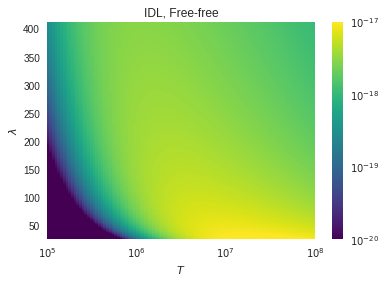

In [11]:
wmesh,tmesh = np.meshgrid(ssw_continuum['wavelength'],10.**ssw_continuum['temperature'])
plt.pcolormesh(tmesh,wmesh,(ssw_continuum['ff']),
               norm=matplotlib.colors.SymLogNorm(1e-50,vmin=1e-20,vmax=1e-17),
               cmap=matplotlib.cm.viridis
              )
plt.xscale('log')
plt.colorbar()
plt.xlim([1e5,1e8])
plt.xlabel(r'$T$')
plt.ylabel(r'$\lambda$')
plt.title(r'IDL, Free-free')

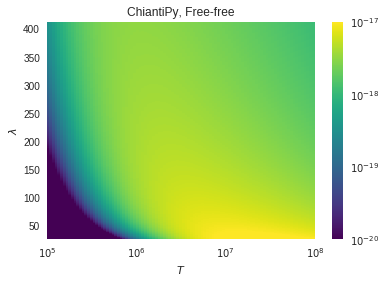

In [12]:
wmesh_py,tmesh_py = np.meshgrid(wavelength,temperature)
plt.pcolormesh(tmesh_py.value,wmesh_py.value,(total_free_free),
               norm=matplotlib.colors.SymLogNorm(1e-50,
                                                 vmin=1e-20,
                                                 vmax=1e-17
                                                ),
               cmap=matplotlib.cm.viridis
              )
plt.xscale('log')
plt.title(r'ChiantiPy, Free-free')
plt.xlabel(r'$T$')
plt.ylabel(r'$\lambda$')
plt.colorbar()

Now plot the difference between the two.

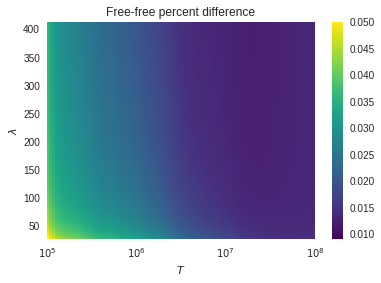

In [18]:
plt.pcolormesh(tmesh,wmesh,
               np.fabs(ssw_continuum['ff'] - total_free_free)/(ssw_continuum['ff'] + total_free_free)/2.,
               #norm=matplotlib.colors.SymLogNorm(1e-50,
                                                  vmin=0.05,
                                                  vmax=0.009,
                #                                  ),
               cmap=matplotlib.cm.viridis
              )
plt.xscale('log')
plt.colorbar()
plt.xlim([1e5,1e8])
plt.xlabel(r'$T$')
plt.ylabel(r'$\lambda$')
plt.title(r'Free-free percent difference')

## Free-bound comparison

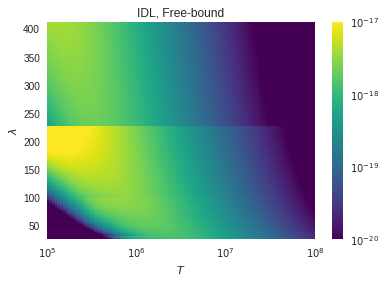

In [19]:
wmesh,tmesh = np.meshgrid(ssw_continuum['wavelength'],10.**ssw_continuum['temperature'])
plt.pcolormesh(tmesh,wmesh,(ssw_continuum['fb']),
               norm=matplotlib.colors.SymLogNorm(1e-50,vmin=1e-20,vmax=1e-17),
               cmap=matplotlib.cm.viridis
              )
plt.xscale('log')
plt.colorbar()
plt.xlim([1e5,1e8])
plt.xlabel(r'$T$')
plt.ylabel(r'$\lambda$')
plt.title(r'IDL, Free-bound')

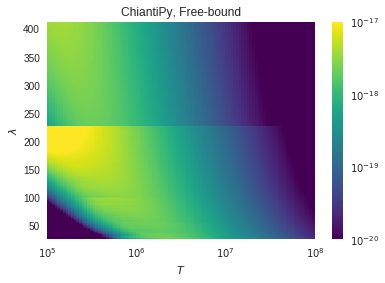

In [20]:
wmesh_py,tmesh_py = np.meshgrid(wavelength,temperature)
plt.pcolormesh(tmesh_py.value,wmesh_py.value,(total_free_bound),
               norm=matplotlib.colors.SymLogNorm(1e-50,vmin=1e-20,vmax=1e-17),
               cmap=matplotlib.cm.viridis
              )
plt.xscale('log')
plt.title(r'ChiantiPy, Free-bound')
plt.xlabel(r'$T$')
plt.ylabel(r'$\lambda$')
plt.colorbar()

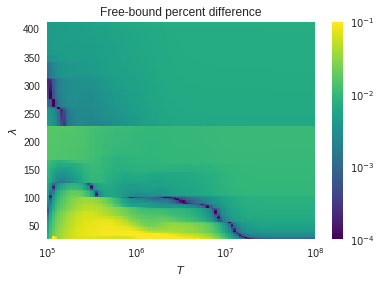

In [21]:
plt.pcolormesh(tmesh,wmesh,
               np.fabs(ssw_continuum['fb'] - total_free_bound)/(ssw_continuum['fb'] + total_free_bound)/2.,
               norm=matplotlib.colors.SymLogNorm(1e-50,
                                                 vmin=0.0001,
                                                 vmax=0.1,
                                                ),
               cmap=matplotlib.cm.viridis
              )
plt.xscale('log')
plt.colorbar()
plt.xlim([1e5,1e8])
plt.xlabel(r'$T$')
plt.ylabel(r'$\lambda$')
plt.title(r'Free-bound percent difference')